In [119]:
import os
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import re


# Enable MPS fallback for operations not supported on the GPU
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Select device: use MPS (Metal Performance Shaders) if available, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")



Using device: mps


In [120]:
# Loading in CSV file that was scraped into Pandas DataFrame
filepath = '../data/reddit_stock_scrape20250420.csv'
reddit_data = pd.read_csv(filepath)

try:
    reddit_data['created']= pd.to_datetime(reddit_data['created'], format='%Y-%m-%d %H:%M:%S')
except:
    print("error")

reddit_data['date_only'] = reddit_data['created'].dt.date
                                          
# Combined Clean title and Body text
reddit_data['combined_text'] = reddit_data['clean_title'].fillna('') + ' ' + reddit_data['clean_selftext'].fillna('')


In [121]:
# Initialiing Sentiment analyzers
vader = SentimentIntensityAnalyzer()
bert_model = "ProsusAI/finbert"
nlp = pipeline(task='sentiment-analysis', model=bert_model, tokenizer=bert_model, device=device, torch_dtype=torch.float32)


In [122]:
def compute_vader_sentiment(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {'neg':0, 'neu': 1, 'pos':0, 'compound': 0}
    return vader.polarity_scores(text)


def compute_finbert_sentiment(texts):
    """Processing texts in batches to speed up FinBERT analysis.
    Returns a list of sentiment results (each a dict with keys 'label' and 'score'),
    with the same length and order as the input list.
    """
    if not texts:
        return []
    
    # Initialize results with None for every text
    results = [None] * len(texts)
    valid_indices = []
    valid_texts = []
    
    # For each text, if it's empty, assign a default result,
    # otherwise record its index and process the text.
    for i, text in enumerate(texts):
        if not isinstance(text, str) or len(text.strip()) == 0:
            results[i] = {'label': 'neutral', 'score': 1.0}
        else:
            valid_indices.append(i)
            valid_texts.append(text[:512])  # truncate to 512 characters
    
    # Process valid texts in batches
    batch_size = 16
    for i in range(0, len(valid_texts), batch_size):
        batch = valid_texts[i:i+batch_size]
        batch_results = nlp(batch)
        
        # Place each result into its original position
        for j, result in enumerate(batch_results):
            idx = valid_indices[i + j]
            results[idx] = result
    
    return results

def normalize_sentiment(score, min_score=-1, max_score=1):
    """Normalize sentiment score to the range [0, 1]."""
    return (score - min_score) / (max_score - min_score) * 100




In [123]:
# Process the data with both models
print("Computing VADER sentiment...")
title_vader = reddit_data['clean_title'].apply(compute_vader_sentiment)
post_vader = reddit_data['clean_selftext'].apply(compute_vader_sentiment)

# Extract compound scores
reddit_data['title_sentiment_vader'] = title_vader.apply(lambda x: x['compound'])
reddit_data['post_sentiment_vader'] = post_vader.apply(lambda x: x['compound'])

# Process FinBERT in batches for efficiency
print("Computing FinBERT sentiment for titles...")
title_finbert = compute_finbert_sentiment(reddit_data['clean_title'].tolist())
print("Computing FinBERT sentiment for posts...")
post_finbert = compute_finbert_sentiment(reddit_data['clean_selftext'].tolist())

# Process FinBERT results
reddit_data['title_sentiment_finbert'] = [
    finbert['score'] if finbert['label'] == 'positive' else 
    -finbert['score'] if finbert['label'] == 'negative' else 0
    for finbert in title_finbert
]

reddit_data['post_sentiment_finbert'] = [
    finbert['score'] if finbert['label'] == 'positive' else 
    -finbert['score'] if finbert['label'] == 'negative' else 0
    for finbert in post_finbert
]

# Calculate weighted sentiment scores
# Title is weighted more heavily (3:1) as it often contains the main sentiment
reddit_data['title_weight'] = 0.75
reddit_data['post_weight'] = 0.25

# Set post_weight to 0 if post is empty
mask = reddit_data['clean_selftext'].isna() | (reddit_data['clean_selftext'] == '')
reddit_data.loc[mask, 'post_weight'] = 0
reddit_data.loc[mask, 'title_weight'] = 1

# Calculate combined scores for each model
reddit_data['vader_score'] = (reddit_data['title_sentiment_vader'] * reddit_data['title_weight'] + 
                    reddit_data['post_sentiment_vader'] * reddit_data['post_weight'])

reddit_data['finbert_score'] = (reddit_data['title_sentiment_finbert'] * reddit_data['title_weight'] + 
                      reddit_data['post_sentiment_finbert'] * reddit_data['post_weight'])

# Calculate ensemble score (average of both models)
reddit_data['sentiment_score'] = (reddit_data['vader_score'] + reddit_data['finbert_score']) / 2

# Normalize to 0-100 scale for easier interpretation
reddit_data['sentiment_normalized'] = normalize_sentiment(reddit_data['sentiment_score'])

# Add sentiment categories
def categorize_sentiment(score):
    if score < -0.5:
        return 'very_negative'
    elif score < -0.1:
        return 'negative'
    elif score <= 0.1:
        return 'neutral'
    elif score <= 0.5:
        return 'positive'
    else:
        return 'very_positive'

reddit_data['sentiment_category'] = reddit_data['sentiment_score'].apply(categorize_sentiment)

# === Option A: Explode multi‑ticker posts into one row per ticker ===
if 'tickers_' in reddit_data.columns:
    # 1. fill NaN, split comma‑lists, explode
    reddit_data['tickers_'] = reddit_data['tickers_'].fillna('')
    reddit_data['ticker_list'] = (
        reddit_data['tickers_']
          .str.split(',')
          .apply(lambda toks: [t.strip() for t in toks if t.strip()])
    )
    reddit_data = (
        reddit_data
          .explode('ticker_list')
          .rename(columns={'ticker_list':'ticker'})
          .drop(columns=['tickers_'])
    )
    print(f"Exploded to {len(reddit_data)} rows (one per post‑ticker).")
else:
    print("Warning: no 'tickers_' column to explode, skipping multi‑ticker handling.")

# Now drop the intermediate text columns
drop_cols = ['clean_title','clean_selftext','combined_text']
reddit_data = reddit_data.drop(columns=[c for c in drop_cols if c in reddit_data.columns])


# Save the exploded, per‑ticker sentiment file
reddit_data.to_csv('../data/redditsentiment.csv', index=False)
print("Final columns:", reddit_data.columns.tolist())


# Display summary
print("\nSentiment Summary:")
print(f"Total posts analyzed: {len(reddit_data)}")
print("\nOverall sentiment distribution:")
print(reddit_data['sentiment_category'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

# Display sample results
print("\nSample results (5 random rows):")
sample_cols = [ 'sentiment_score', 'sentiment_normalized', 'sentiment_category']
if 'tickers_' in reddit_data.columns:
    sample_cols.append('tickers_')
print(reddit_data[sample_cols].sample(5))

Computing VADER sentiment...
Computing FinBERT sentiment for titles...
Computing FinBERT sentiment for posts...
Exploded to 2356 rows (one per post‑ticker).
Final columns: ['subreddit', 'id', 'created', 'score', 'upvote_ratio', 'num_comments', 'url', 'has_target_stock', 'date_only', 'title_sentiment_vader', 'post_sentiment_vader', 'title_sentiment_finbert', 'post_sentiment_finbert', 'title_weight', 'post_weight', 'vader_score', 'finbert_score', 'sentiment_score', 'sentiment_normalized', 'sentiment_category', 'ticker']

Sentiment Summary:
Total posts analyzed: 2356

Overall sentiment distribution:
sentiment_category
neutral          38.5%
positive         36.0%
negative         20.2%
very_negative     3.3%
very_positive     2.0%
Name: proportion, dtype: object

Sample results (5 random rows):
      sentiment_score  sentiment_normalized sentiment_category
69           0.000000             50.000000            neutral
1790         0.114888             55.744375           positive
734     

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

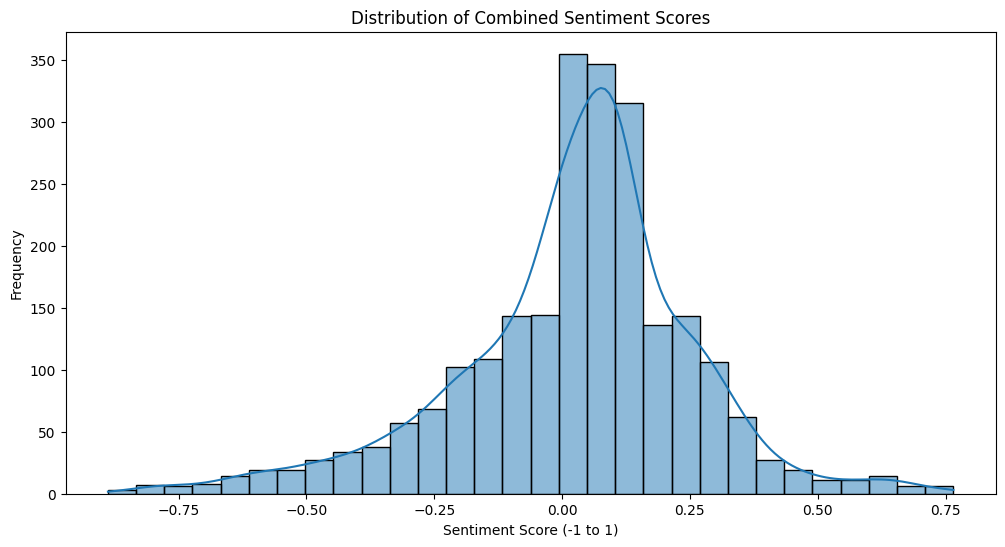

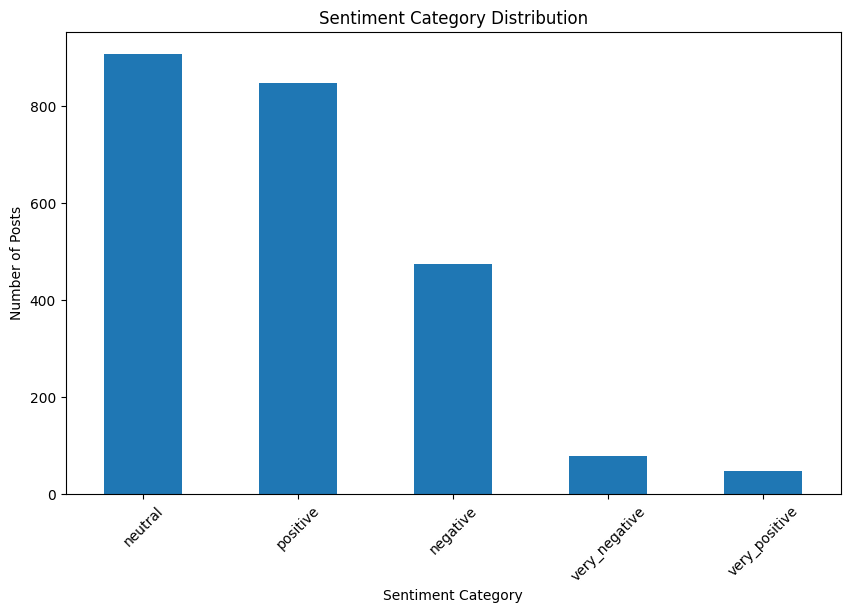

In [125]:
plt.figure(figsize=(12, 6))
sns.histplot(reddit_data['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Combined Sentiment Scores')
plt.xlabel('Sentiment Score (-1 to 1)')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
reddit_data['sentiment_category'].value_counts().plot(kind='bar')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

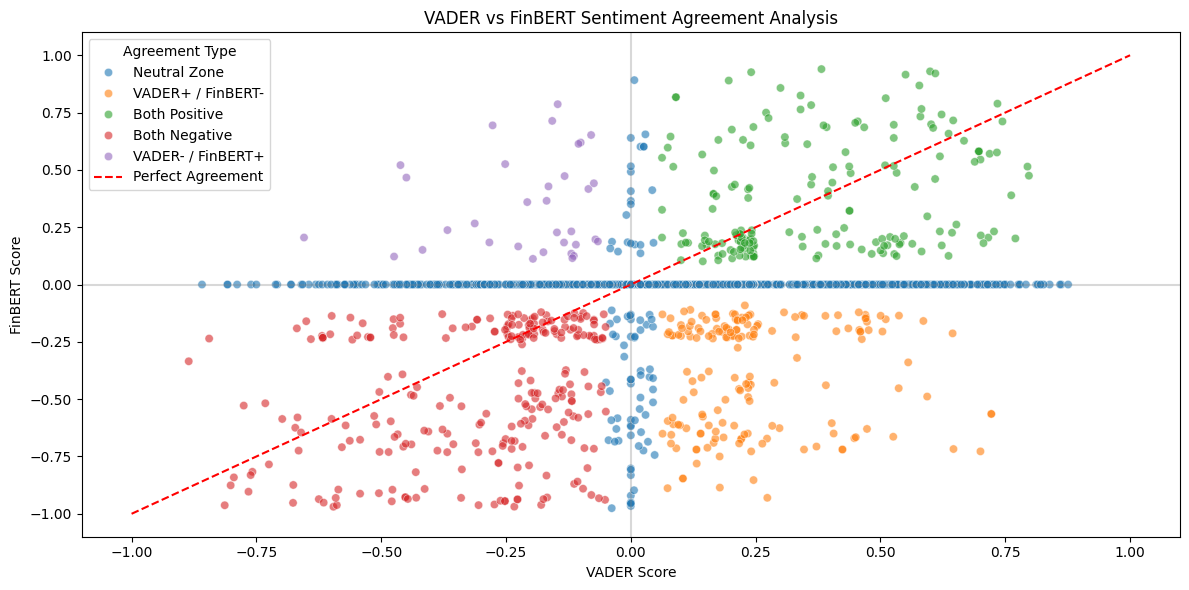

In [126]:
# Create quadrant categories
reddit_data['agreement'] = 'Neutral Zone'
reddit_data.loc[(reddit_data['vader_score'] > 0.05) & (reddit_data['finbert_score'] > 0.05), 'agreement'] = 'Both Positive'
reddit_data.loc[(reddit_data['vader_score'] < -0.05) & (reddit_data['finbert_score'] < -0.05), 'agreement'] = 'Both Negative'
reddit_data.loc[(reddit_data['vader_score'] > 0.05) & (reddit_data['finbert_score'] < -0.05), 'agreement'] = 'VADER+ / FinBERT-'
reddit_data.loc[(reddit_data['vader_score'] < -0.05) & (reddit_data['finbert_score'] > 0.05), 'agreement'] = 'VADER- / FinBERT+'

plt.figure(figsize=(12, 6))
sns.scatterplot(x='vader_score', y='finbert_score', hue='agreement', data=reddit_data, alpha=0.6)
plt.title('VADER vs FinBERT Sentiment Agreement Analysis')
plt.xlabel('VADER Score')
plt.ylabel('FinBERT Score')
plt.plot([-1, 1], [-1, 1], 'r--', label='Perfect Agreement')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
plt.legend(title='Agreement Type')
plt.tight_layout()
plt.show()

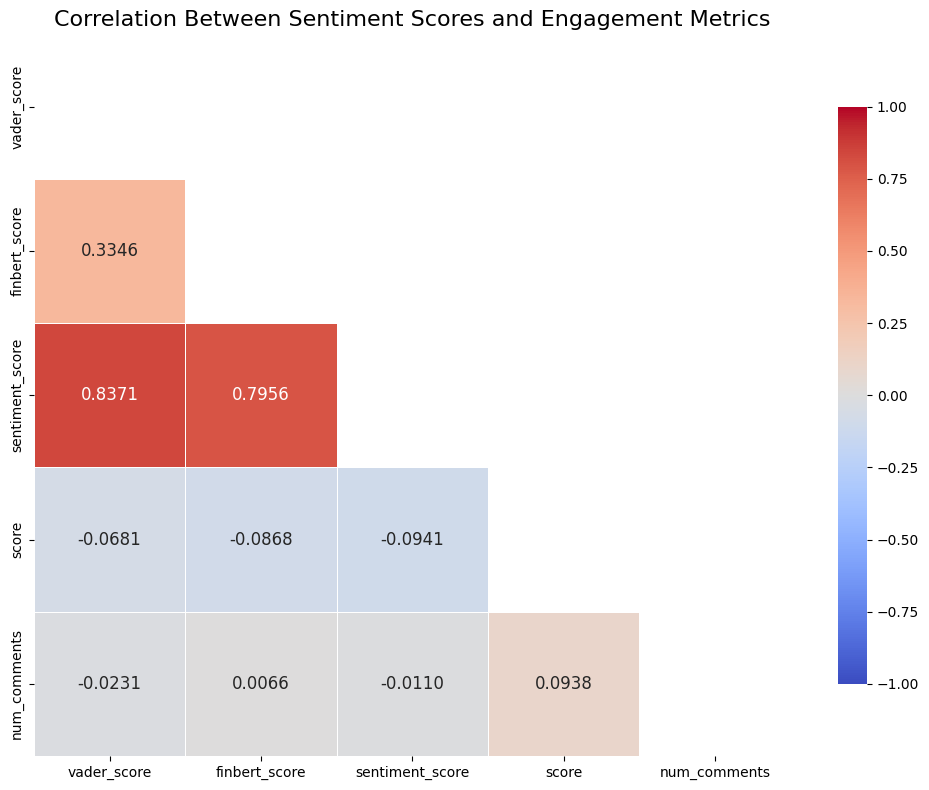

In [127]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create mask for upper triangle
sns.heatmap(corr_matrix, 
            annot=True,               # Show correlation values
            cmap='coolwarm',          # Color scheme
            vmin=-1, vmax=1,          # Fix color scale
            mask=mask,                # Apply mask to hide redundant values
            annot_kws={"size": 12},   # Larger annotation font
            fmt='.4f',                # Round to 4 decimal places
            linewidths=0.5,           # Add cell borders
            cbar_kws={"shrink": 0.8}) # Adjust colorbar size

plt.title('Correlation Between Sentiment Scores and Engagement Metrics', fontsize=16)
plt.tight_layout()
plt.show()

In [128]:
if 'subreddit' in reddit_data.columns:
    # keep only the bare subreddit name (e.g.  r/stocks  ->  stocks)
    reddit_data['subreddit'] = (
        reddit_data['subreddit']
          .astype(str)
          .str.replace(r'^r\/', '', regex=True)      # drop leading "r/"
          .str.strip()
          .str.lower()
    )
    reddit_data = reddit_data.drop(columns=['subreddit'])

# 2) Aggregate sentiment per day  ─────────────────────────────────────────────
sentiment_cols = ['sentiment_score', 'sentiment_normalized']

daily_agg = (
    reddit_data
      .groupby('date_only')
      .agg(
          posts_per_day              = ('sentiment_score', 'size'),
          avg_sentiment              = ('sentiment_score', 'mean'),
          avg_sentiment_normalized   = ('sentiment_normalized', 'mean')
      )
      .reset_index()
      .sort_values('date_only')
)

print("Preview of daily aggregates:")
display(daily_agg.head())

# 3) Persist to CSV  ───────────────────────────────────────────────────────────
out_path = '../data/aggregatesentiment.csv'
daily_agg.to_csv(out_path, index=False)
print(f"\n✅  Saved daily sentiment aggregates → {out_path}")

Preview of daily aggregates:


,date_only,posts_per_day,avg_sentiment,avg_sentiment_normalized
0,2025-03-29,15,0.137979,56.898958
1,2025-03-30,27,0.144467,57.223372
2,2025-03-31,27,0.138896,56.944821
3,2025-04-01,28,0.078885,53.944254
4,2025-04-02,92,0.024197,51.209840



✅  Saved daily sentiment aggregates → ../data/aggregatesentiment.csv
